# Predicting EPL Result Using Poisson Distribution
Poisson Distribution Wiki: [Link](https://en.wikipedia.org/wiki/Poisson_distribution)

## Notebook Contents:

[Objective](#Objective)  
[Data Prep/Summary](#DPS)  
[Exploratory Data Analysis](#EDA)  
[Poisson Distribution](#PD)

<a id='Objective'></a>
### Objective:

Predict the probability of each matches results of English Premier League using past season data using Poisson distribution.<br>
We are not doing any statistical modeling here. We simply predict the probability of how many goals home/away team would score in every single game in season.<br>

<a id='DPS'></a>
### Data Prep/Summary:
* English Premier League Stats (2012/13 - 2017/18)
* English Premier League Fixtures (2012/13 - 2017/18)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For Poisson distribution
from scipy.stats import poisson

In [2]:
# Read past seasons data which have been cleaned beforehands
# We want to know which season ('Season')
# We want teamnames, total number of goals each team scored and allowed ('Team', 'HGF', 'HGA')
# We calculate each teams offensive and defensive rating ('H_Att', 'A_Att', 'H_Def', 'A_Def')

# IMPORTANT
# Season 13 means Season 12/13 
# We will be able to predict the result using features 

epl_data = pd.read_csv('./Data/epl_data.csv')[['Team', 'Season', 'HGF', 'HGA', 'H_Att', 'A_Att', 'H_Def', 'A_Def']]

In [3]:
# Read all season fixtures from 13/14 to 17/18
# We need home/away team and the final result to compare with our prediction
# We want how many goals they score to make useful EDAs

epl_fixture = pd.read_csv('./Data/epl_fixture.csv')[['Season', 'HomeTeam', 'AwayTeam', 'FTR', 'FTHG', 'FTAG']]

<a id='EDA'></a>
### EDA
Number of Goals Scored per Match

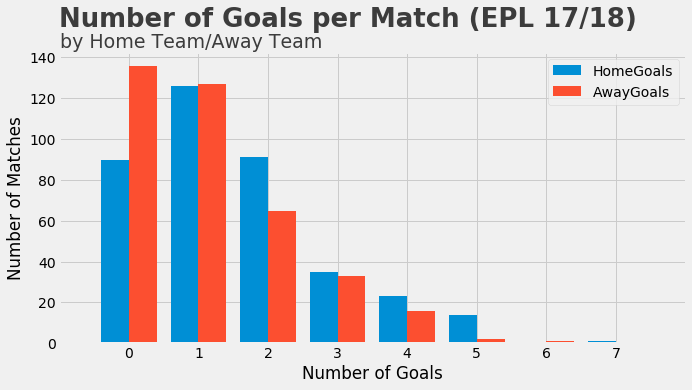

In [4]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,5))
x = epl_fixture[epl_fixture['Season'] == 18]['FTHG'] 
y = epl_fixture[epl_fixture['Season'] == 18]['FTAG'] 
bins = np.linspace(0, 8, 9)
plt.hist([x, y], bins, label=['HomeGoals', 'AwayGoals'], align='left')
plt.legend(loc='upper right')
plt.text(-1, 155, "Number of Goals per Match (EPL 17/18)", fontsize=26, weight='bold', alpha=.75)
plt.text(-.99, 145 , "by Home Team/Away Team", fontsize=19, alpha=.75)
plt.ylabel("Number of Matches")
plt.xlabel("Number of Goals")
plt.xlim(left=-1, right = 8)
plt.xticks(bins[:-1]);

<a id='PD'></a>
### Poisson Distribution
Poisson process, which is essentially a way to model random events at a known rate, we generate two Poisson distributions around those scores. Those give us the likelihood that each team will score no goals, one goal, two goals, etc. (Source:[How Our 2018 World Cup Predictions Work (FiveThirtyEight)](https://fivethirtyeight.com/features/how-our-2018-world-cup-predictions-work/))

In [5]:
def result_percentage(epl_data, hometeam, awayteam, season):
    '''
    returns array of size 2.
    list of percentage of hometeam win/away win/draw
    dataframe of percentage of how many goals each team scores in 90 minutes (min: 0, max: 5)
    '''
    score = []
    dataframe = epl_data[epl_data['Season'] == season]

    if len(dataframe) > 0:

        home_avg = dataframe['HGF'].sum()/380
        away_avg = dataframe['HGA'].sum()/380
        
        home_score = float(dataframe[dataframe['Team'] == hometeam]['H_Att']) * float(dataframe[dataframe['Team'] == awayteam]['A_Def']) * home_avg
        away_score = float(dataframe[dataframe['Team'] == awayteam]['A_Att']) * float(dataframe[dataframe['Team'] == hometeam]['H_Def']) * away_avg
        # maximum score for a team is 5
        for goals in range(0, 6):
            scores = {}
            scores['Home'] = (poisson.pmf(goals, home_score)) # Hometeam score
            scores['Away'] = (poisson.pmf(goals, away_score)) # away score

            if len(scores) == 2:
                        score.append(scores)

        score = pd.DataFrame(score, columns=(['Home', 'Away']))

    # % of home team winning
    # home score > away score
    # home[1] * away[0]
    # home[2] * away[0] + home[2] * away[1]
    # home[3] * away[0] + home[3] * away[1] + home[3] * away[2]
    # home[4] * away[0] + home[4] * away[1] + home[4] * away[2] + home[4] * away[3]
    # home[5] * away[0] + home[5] * away[1] + home[5] * away[2] + home[5] * away[3]+  home[5] * away[4]
    home_w = 0
    away_w = 0
    draw = 0
    result = []
    for home in range(1, len(score)):
        for away in range(0, home):
            home_w += (score['Home'][home] * score['Away'][away])
    result.append(home_w)

    for away in range(1, len(score)):
        for home in range(0, away):
            away_w += (score['Home'][home] * score['Away'][away])
    result.append(away_w)

    for home in range(0, len(score)):
        away = home
        draw += (score['Home'][home] * score['Away'][away])
    result.append(draw)

    return result, score

In [6]:
# Percentage of the number goals in 18/19 Arsenal(Home) vs Chelsea(Away) used EPL Season 17/18 Data
mat = result_percentage(epl_data, 'Arsenal', 'Chelsea', 18)[1]

In [7]:
# 6 x 6 Matrix form
result = []
for i in mat['Home']:
    for j in mat['Away']:
        result.append(round(i * j, 4))
result = np.reshape(result, (6,6))
df_ = pd.DataFrame(result, index=range(0,6), columns=('0', '1', '2', '3', '4', '5'))
df_.index.names = ['Home']
df_.columns.names = ['Away']

In [8]:
# Total Probability of W/D/L
temp = pd.DataFrame(result_percentage(epl_data, 'Arsenal', 'Chelsea', 18)[0], index=('Home Win', 'Away Win', 'Draw')).T

In [9]:
def highlight_cols(x):
    #copy df to new - original data are not changed
    df = x.copy()
    #select all values to default value
    df.loc[:,:] = 'background-color: lightgoldenrodyellow'
    #overwrite values 
    df.iloc[range(1,6),0] = 'background-color: lightskyblue'
    df.iloc[range(2,6),1] = 'background-color: lightskyblue'
    df.iloc[range(3,6),2] = 'background-color: lightskyblue'
    df.iloc[range(4,6),3] = 'background-color: lightskyblue'
    df.iloc[range(5,6),4] = 'background-color: lightskyblue'

    df.iloc[0, range(1,6)] = 'background-color: lightpink'
    df.iloc[1, range(2,6)] = 'background-color: lightpink'
    df.iloc[2, range(3,6)] = 'background-color: lightpink'
    df.iloc[3, range(4,6)] = 'background-color: lightpink'
    df.iloc[4, range(5,6)] = 'background-color: lightpink'
    #return color df
    return df    
df_.style.apply(highlight_cols, axis=None)

Away,0,1,2,3,4,5
Home,,,,,,
0,0.0249,0.0384,0.0297,0.0153,0.0059,0.0018
1,0.0535,0.0826,0.0638,0.0329,0.0127,0.0039
2,0.0574,0.0887,0.0686,0.0353,0.0136,0.0042
3,0.0411,0.0636,0.0491,0.0253,0.0098,0.003
4,0.0221,0.0341,0.0264,0.0136,0.0052,0.0016
5,0.0095,0.0147,0.0113,0.0058,0.0023,0.0007


In [10]:
mat

,Home,Away
0,0.116639,0.213280
1,0.250619,0.329550
2,0.269249,0.254601
3,0.192842,0.131132
4,0.103589,0.050655
5,0.044516,0.015654


In [11]:
temp.rename(index={0: "Probability"})

,Home Win,Away Win,Draw
Probability,0.493166,0.272024,0.207251


In [12]:
# Getting the final result of a game
def decision(result_p):
    if result_p[2] > result_p[1] and result_p[2] > result_p[0]:
        return 'D'
    elif result_p[0] > result_p[1] and result_p[0] > result_p[2]:
        return 'H'
    elif result_p[1] > result_p[0] and result_p[1] > result_p[2]:
        return 'A'

In [13]:
# Predict each game
def predict(fixture, data):
    for i in range(len(fixture)):
        season = fixture.loc[i, 'Season']
        hometeam = fixture.loc[i, 'HomeTeam']
        awayteam = fixture.loc[i, 'AwayTeam']
        if (hometeam in list(data[data['Season'] == (season - 1)]['Team'])) & (awayteam in list(data[data['Season'] == (season - 1)]['Team'])):
            result = result_percentage(data, hometeam, awayteam, season - 1)[0]
            fixture.loc[i, 'Predict'] = decision(result)
            fixture.loc[i, 'W'] = result[0]
            fixture.loc[i, 'D'] = result[2]
            fixture.loc[i, 'L'] = result[1]
            fixture.loc[:, 'Result'] = (fixture.loc[:, 'FTR'] == fixture.loc[:, 'Predict']) * 1
        else:
            pass

In [14]:
predict(epl_fixture, epl_data)

In [15]:
poisson_prediction = epl_fixture[['Season', 'HomeTeam', 'AwayTeam', 'W', 'D', 'L', 'FTR', 'Predict', 'Result']].dropna()

In [16]:
def highlight_cols_poi(x):
    #copy df to new - original data are not changed
    df = x.copy()
    #select all values to default value
    #overwrite values grey color
    df[df['Result']==1] = 'background-color: lightskyblue'
    df[df['Result']==0] = 'background-color: lightpink'

    #return color df
    return df    
poisson_prediction.style.apply(highlight_cols_poi, axis=None)

In [17]:
print('Prediction Using Poisson Distribution:', round(poisson_prediction.Result.mean(), 5))

Prediction Using Poisson Distribution: 0.51441


In [18]:
# Predict each game
def predict_cur(fixture, data):
    for i in range(len(fixture)):
        season = fixture.loc[i, 'Season']
        hometeam = fixture.loc[i, 'HomeTeam']
        awayteam = fixture.loc[i, 'AwayTeam']
        if (hometeam in list(data[data['Season'] == (season - 1)]['Team'])) & (awayteam in list(data[data['Season'] == (season - 1)]['Team'])):
            result = result_percentage(data, hometeam, awayteam, season - 1)[0]
            fixture.loc[i, 'Predict'] = decision(result)
            fixture.loc[i, 'W'] = result[0]
            fixture.loc[i, 'D'] = result[2]
            fixture.loc[i, 'L'] = result[1]
            #fixture.loc[:, 'Result'] = (fixture.loc[:, 'FTR'] == fixture.loc[:, 'Predict']) * 1
        else:
            pass

In [19]:
# empty full fixture for 18/19
teams = sorted(set(pd.read_csv('./Data/matchday.csv')['Team']))
final2 = pd.DataFrame(columns=['HomeTeam', 'AwayTeam'])
final2['HomeTeam'] = teams * 20
for i in range(0, 400):
     final2.loc[i, 'AwayTeam'] = teams[int(i/20)]
final2 = final2[final2['HomeTeam'] != final2['AwayTeam']].reset_index(drop=True)
final2['Season'] = 19

In [20]:
predict_cur(final2, epl_data)

In [21]:
standing2 = pd.DataFrame(columns=(['Team', 'W', 'D', 'L', 'PTS', 'Rank']))
standing2['Team'] = teams
standing2[['PTS', 'W', 'L', 'D', 'Rank']]= 0

In [22]:
for i in range(len(final2)):
    if final2.loc[i, 'Predict'] == 'H':
        standing2.loc[standing2['Team'] == final2.loc[i, 'HomeTeam'], 'PTS'] += 3
        standing2.loc[standing2['Team'] == final2.loc[i, 'HomeTeam'], 'W'] += 1
        standing2.loc[standing2['Team'] == final2.loc[i, 'AwayTeam'], 'L'] += 1

    if final2.loc[i, 'Predict'] == 'A':
        standing2.loc[standing2['Team'] == final2.loc[i, 'AwayTeam'], 'PTS'] += 3
        standing2.loc[standing2['Team'] == final2.loc[i, 'AwayTeam'], 'W'] += 1
        standing2.loc[standing2['Team'] == final2.loc[i, 'HomeTeam'], 'L'] += 1
        
    if final2.loc[i, 'Predict'] == 'D':
        standing2.loc[standing2['Team'] == final2.loc[i, 'HomeTeam'], 'PTS'] += 1
        standing2.loc[standing2['Team'] == final2.loc[i, 'AwayTeam'], 'PTS'] += 1
        standing2.loc[standing2['Team'] == final2.loc[i, 'AwayTeam'], 'D'] += 1
        standing2.loc[standing2['Team'] == final2.loc[i, 'HomeTeam'], 'D'] += 1


In [23]:
standing2 = standing2.sort_values('PTS', ascending=False)
standing2 = standing2.reset_index(drop=True)
for i in range(len(standing2)):
    standing2.loc[i, 'Rank'] = i + 1
standing2 = standing2.set_index('Rank')

In [24]:
standing2

,Team,W,D,L,PTS
Rank,,,,,
1,Manchester City,32,0,0,96
2,Tottenham,27,0,5,81
3,Manchester Utd,27,0,5,81
4,Liverpool,26,0,6,78
5,Chelsea,24,0,8,72
6,Leicester City,18,0,14,54
7,Burnley,17,2,13,53
8,Arsenal,17,0,15,51
9,Newcastle Utd,12,1,19,37
